# Predict ED admission probability

This notebook demonstrates the first stage of prediction, to generate a probability of admission for each patient in the ED. 

As one of the modelling decisions is to send predictions at specified times of day, we tailor the models to these times and train one model for each time. The dataset used for this modelling is derived from snapshots of visits at each time of day. The times of day are set in config.json file in the root directory of this repo. 

A patient episode (visit) may well span more than one of these times, so we need to consider how we will deal with the occurence of multiple snapshots per episode. At each of these times of day, we will use only one training sample from each hospital episode.

Separation of the visits into training, validation and test sets will be done chronologically into a training, validation and test set.

Here the logic for training a model is hidden in a function which uses an XGBoost classifier. We show how to call the function, and how to interrogate the results. You may have your own trained models, in which case skip this notebook and move onto to the one showing the aggregation to bed level [4b_Predict_demand_from_patients_in_ED.ipynb](4b_Predict_demand_from_patients_in_ED.ipynb)

Evaluation will be done separately in [5_Evaluate_model_performance.ipynb](5_Evaluate_model_performance.ipynb). 


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Set file paths and load data

File paths are defined in `set_file_paths()`. Here, the files are loaded from `data-public` in the root of the repository. When you first download or install this repository, this folder will be empty. You have two options: 

* Copy the two files from the `data-synthetic` folder into the `data-public` folder. Note that, if you run these notebooks with synthetic data, you will get artificially good performance of the models
* Request files that contain real patient data to put in the `data-public` folder; contact the owner of the repository; see the README in the root of the repository

In [3]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml')

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


In [4]:
import pandas as pd
from patientflow.load import load_data

# load data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

Note that, in the output below, each row has a snapshot_id as an index. In the notebooks that follow, we retain the same values of snapshot_id throughout, meaning that they are consistent across the original dataset visits and the training, validation and test subsets of visits. At any point, when looking at output (eg the predicted probability of admission for a patient), you should be able to track that output back to the original row in the ed_visits dataset.

In [5]:
ed_visits.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,4/17/2031,"(12, 0)",30767,1920,F,55-64,Ambulance,majors,4,107,...,NaN,NaN,NaN,NaN,NaN,train,[],False,15795,medical
1,4/17/2031,"(15, 30)",30767,14520,F,55-64,Ambulance,majors,5,138,...,4.61,7.474,8.77,NaN,NaN,train,[],False,860,medical
2,12/10/2031,"(15, 30)",36297,9180,M,75-102,NaN,majors,4,127,...,4.82,7.433,6.59,NaN,NaN,test,[],False,76820,surgical
3,3/28/2031,"(6, 0)",53554,2220,F,35-44,Public Trans,rat,3,356,...,NaN,NaN,NaN,NaN,NaN,train,[],False,54886,medical
4,3/28/2031,"(9, 30)",53554,14820,F,35-44,Public Trans,majors,4,375,...,4.00,7.536,13.03,NaN,NaN,train,[],False,6265,medical


If you are looking at synthetic or public data, the date have been shifted into the future, as shown below. This is to minimise any risk of a patient being identifiable. 

In [6]:
# print start and end dates
print(ed_visits.snapshot_date.min())
print(ed_visits.snapshot_date.max())

10/1/2031
9/9/2031


## Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [7]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )


Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive


## Prediction times

The data has been prepared as a series of snapshots of each patient's data at five moments during the day. These five moments are the times when the bed managers wish to receive predictive models of emergency demand. If a patient arrives in the ED at 4 am, and leaves at 11 am, they will be represented in the 06:00 and 09:30 prediction times. Everything known about a patient is included up until that moment is included in that snapshot.

The predition times are presented as tuples in the form (hour, minute). 

From the output below we can see that there are most snapshots at 15:30 - since afternoons are typically the busiest times in the ED - and least at 06:00. 

In [8]:
print("\nTimes of day at which predictions will be made")
print(ed_visits.prediction_time.unique())


Times of day at which predictions will be made
[(12, 0) (15, 30) (6, 0) (9, 30) (22, 0)]


In [9]:
print("\nNumber of observations for each prediction time")
print(ed_visits.prediction_time.value_counts())


Number of observations for each prediction time
prediction_time
(15, 30)    22279
(12, 0)     19075
(22, 0)     18842
(9, 30)     11421
(6, 0)       8197
Name: count, dtype: int64


If you use different data, check that the prediction times in your dataset aligns with the specified times of day set in the parameters file config.yaml. That is because, later, we will use these times of day to evaluate the predictions. The evaluation will fail if the data loaded does not match. 

## Separate into training, validation and test sets

The first task in model development is to split the dataset into a training, validation and test set using a temporal split. Using a using a temporal split (rather than randomly assigning visits to each set) is appropriate for tasks where the model needs to be validated on unseen, future data.

The training set is used to fit the model parameters, the validation set helps tune hyperparameters and evaluate the model during development to prevent overfitting, and the test set provides an unbiased evaluation of the final model's performance on completely unseen data.

I first load the training, validation and test set dates from the configuration file

In [10]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )


Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive


In [11]:
from patientflow.prepare import create_temporal_splits

train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

Split sizes: [53801, 6519, 19494]


## Train a XGBoost Classifier for each time of day, and save the best model

### About the approach to model training

The first step is to load a transformer for the training data to turn it into a format that our ML classifier can read. This is done using a custom function (written for this package) called `create_column_transformer()` which in turn calls `ColumnTransfomer()`, a standard method in scikit-learn. 

The `ColumnTransformer` in scikit-learn is a tool that applies different transformations or preprocessing steps to different columns of a dataset in a single operation. OneHotEncoder converts categorical data into a format that can be provided to machine learning algorithms; without this, the model might interpret the categorical data as numerical, which would lead to incorrect results. OrdinalEncoder converts categorical data into ordered numerical values to reflect the inherent order in the age groups. It is the job of the modeller to indicate to the model how to handle each variables, based on your knowledge of what they represent. Here, `age_group`, `latest_obs_manchester_triage_acuity`, `latest_obs_objective_pain_score` and `latest_obs_level_of_consciousness` are all marked as ordered categories. 

In [12]:

ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
    }




Certain columns in the dataset provided are not used in training the admissions model. I specify them here

In [13]:
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','consultation_sequence', 'visit_number', 'specialty', 'final_sequence', 'training_validation_test']

I also specify a grid of hyperparameters; the classifier will iterate though them to find the best fitting model. 


In [14]:
# # minimal grid for expediency
# grid = {"n_estimators": [30], 
#         "subsample": [0.7], 
#         "colsample_bytree": [0.7],
# }


# grid for hyperparameter tuning
grid = {
    'n_estimators':[30, 40, 50],
    'subsample':[0.7,0.8,0.9],
    'colsample_bytree': [0.7,0.8,0.9],

}

We are interested in predictions at different times of day. So we will train a model for each time of day. We will filter each visit so that it only appears once in the training data. 

We iterate through the hyperparameter grid defined above to find the best model for each time of day, keeping track of the best model and its results. When evaluating the best configuration from among the range of hyperparameter options, we will save common ML metrics (AUC, AUPRC and logloss) and compare each configuration for the best (lowest) logloss. This is done by looking at performance on a validation set. 

The best model is saved, as is a dictionary of its metadata, including

* the parameters used in this version of training
* how many visits were in training, validation and test sets
* class balance in each set - the proportion of positive (ie visit ended in admission) to negative (visit ended in discharge) 
* area under ROC curve and log loss (performance metrics) for training (based on 5-fold cross validation), validation and test sets
* List of features and their importances in the model

In [15]:
train_visits.prediction_time.value_counts()

prediction_time
(15, 30)    15054
(12, 0)     12764
(22, 0)     12642
(9, 30)      7671
(6, 0)       5670
Name: count, dtype: int64

Note that the classes are imbalanced. The admitted patients range from 12% to 17% of the total visits.  

In [16]:
train_visits.groupby('prediction_time')['is_admitted'].mean()

prediction_time
(6, 0)      0.172134
(9, 30)     0.130752
(12, 0)     0.124021
(15, 30)    0.154975
(22, 0)     0.164610
Name: is_admitted, dtype: float64

In [52]:
# train admissions model
from patientflow.train.classifiers import train_multiple_classifiers
from patientflow.train.utils import save_model

prediction_times = ed_visits.prediction_time.unique()
model_name = 'admissions'

trained_models = train_multiple_classifiers(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid=grid,
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_times=prediction_times,
    model_name=model_name,
    calibrate_probabilities=False,
    calibration_method='sigmoid',
    use_balanced_training=False,
    visit_col='visit_number' # visit_col is needed to ensure we get only one snapshot for each visit in the training set; snapshots are randomly sampled
)

# save models 
save_model(trained_models, "admissions", model_file_path)
print(f"Models have been saved to {model_file_path}")


Processing: (12, 0)

Processing: (15, 30)

Processing: (6, 0)

Processing: (9, 30)

Processing: (22, 0)
Models have been saved to /Users/zellaking/Repos/patientflow/trained-models/public


## Inspecting the output from model training 

Five models have been trained, each saved under a key which is the name of the model passed into train_all_models() (default value is 'admissions'), with the prediction time appended

In [53]:
print(trained_models.keys())


dict_keys(['admissions_1200', 'admissions_1530', 'admissions_0600', 'admissions_0930', 'admissions_2200'])


If we display the values for one of the items in the dictionary of trained_models, we see that a trained classifer has been returned by the function. 



In [54]:
type(trained_models['admissions_1530'])

patientflow.metrics.TrainedClassifier

Within the object that is returned, various metrics have been saved, including
- how many observations were in th training, validation and test sets
- the class balance (proportion of admitted patients in the whole dataset)
- the best parameters of all combinations tried
- results on training and validation sets
- results on test set
- the model features

In [55]:
trained_models['admissions_1530'].training_results

TrainingResults(prediction_time=(15, 30), training_info={'best_hyperparameters': {'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.9}, 'cv_trials': [HyperParameterTrial(parameters={'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.7}, cv_results={'train_auc': np.float64(0.9580444574749587), 'train_logloss': np.float64(0.17128741291716607), 'train_auprc': np.float64(0.8715806541831641), 'valid_auc': np.float64(0.8185838772831474), 'valid_logloss': np.float64(0.35776512326952187), 'valid_auprc': np.float64(0.49339818684816883)}), HyperParameterTrial(parameters={'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.8}, cv_results={'train_auc': np.float64(0.9608349568241314), 'train_logloss': np.float64(0.16742416684695283), 'train_auprc': np.float64(0.882931124248984), 'valid_auc': np.float64(0.822116547223759), 'valid_logloss': np.float64(0.35205162513739036), 'valid_auprc': np.float64(0.5043328103662739)}), HyperParameterTrial(parameters={'colsample_bytree': 0

To get a better view of the same output

In [56]:
from dataclasses import fields
print("\nDataclass fields in TrainingResults:")
for field in fields(trained_models['admissions_1530'].training_results):
    print(field.name)


Dataclass fields in TrainingResults:
prediction_time
training_info
calibration_info
test_results
balance_info


The prediction time for this model has also been saved.

In [57]:
# See the prediction time for this model
trained_models['admissions_1530'].training_results.prediction_time

(15, 30)

Within the training_results, a training_info object contains information related to model training

In [58]:
metrics_dict = trained_models['admissions_1530'].training_results.training_info
metrics_dict.keys()

dict_keys(['best_hyperparameters', 'cv_trials', 'features', 'dataset_info'])

In [59]:
for key, value in trained_models['admissions_1530'].training_results.training_info.items():
    print(key)

best_hyperparameters
cv_trials
features
dataset_info


In [77]:


prediction_time_model_name = 'admissions_1530'

# Get the results dictionary from cross validation trials
results = trained_models[prediction_time_model_name].training_results.training_info['cv_trials']

# Show the first trial results
results[0].cv_results

{'train_auc': np.float64(0.9580444574749587),
 'train_logloss': np.float64(0.17128741291716607),
 'train_auprc': np.float64(0.8715806541831641),
 'valid_auc': np.float64(0.8185838772831474),
 'valid_logloss': np.float64(0.35776512326952187),
 'valid_auprc': np.float64(0.49339818684816883)}

In [ ]:

training_info = trained_models[prediction_time_model_name].training_results.training_info

def find_best_trial(trials_list):
    """Find the trial with the lowest validation logloss."""
    return min(trials_list, key=lambda trial: trial.cv_results['valid_logloss'])

best_trial = find_best_trial(training_info["cv_trials"])

# print the best parameters
best_parameters = best_trial.parameters
best_parameters

{'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.9}


#### Retreiving saved information about the number of training, validation and test set samples, and the class balance

In [78]:
model_metadata = trained_models[prediction_time_model_name].training_results.training_info
print(f"Number in each set for model called {prediction_time_model_name}:\n{model_metadata['dataset_info']['train_valid_test_set_no']}")

def print_class_balance(d):
    for k in d:
        print(f"{k.split('_')[1]}: {d[k][0]:.1%} neg, {d[k][1]:.1%} pos")


print_class_balance(model_metadata['dataset_info']['train_valid_test_class_balance'])


Number in each set for model called admissions_1530:
{'train_set_no': 14969, 'valid_set_no': 1691, 'test_set_no': 5519}
train: 84.5% neg, 15.5% pos
valid: 79.8% neg, 20.2% pos
test: 81.2% neg, 18.8% pos


Class balance information is also saved in this key, which will store information about the differences between the class balance when forcing the training set to be balanced

In [79]:
trained_models[prediction_time_model_name].training_results.balance_info

{'is_balanced': False,
 'original_size': 14969,
 'balanced_size': 14969,
 'original_positive_rate': np.float64(0.15538780145634312),
 'balanced_positive_rate': np.float64(0.15538780145634312),
 'majority_to_minority_ratio': 1.0}

#### Retreiving saved information about the best parameters for each model

In [80]:
from patientflow.load import get_model_key



def find_best_trial(trials_list):
    """Find the trial with the lowest validation logloss."""
    return min(trials_list, key=lambda trial: trial.cv_results['valid_logloss'])

best_trial = find_best_trial(training_info["cv_trials"])


for prediction_time in train_visits.prediction_time.unique():
    prediction_time_model_name = get_model_key("admissions", prediction_time)
    training_info = trained_models[prediction_time_model_name].training_results.training_info
    best_trial = find_best_trial(training_info["cv_trials"])
    hour, minute = prediction_time
    print(f"Best hyperparameters for {hour:02d}:{minute:02d} model: {best_trial.parameters}")

Best hyperparameters for 12:00 model: {'colsample_bytree': 0.8, 'n_estimators': 30, 'subsample': 0.9}
Best hyperparameters for 15:30 model: {'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.9}
Best hyperparameters for 06:00 model: {'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.9}
Best hyperparameters for 09:30 model: {'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.9}
Best hyperparameters for 22:00 model: {'colsample_bytree': 0.7, 'n_estimators': 30, 'subsample': 0.9}


Plot the performance of each training run.

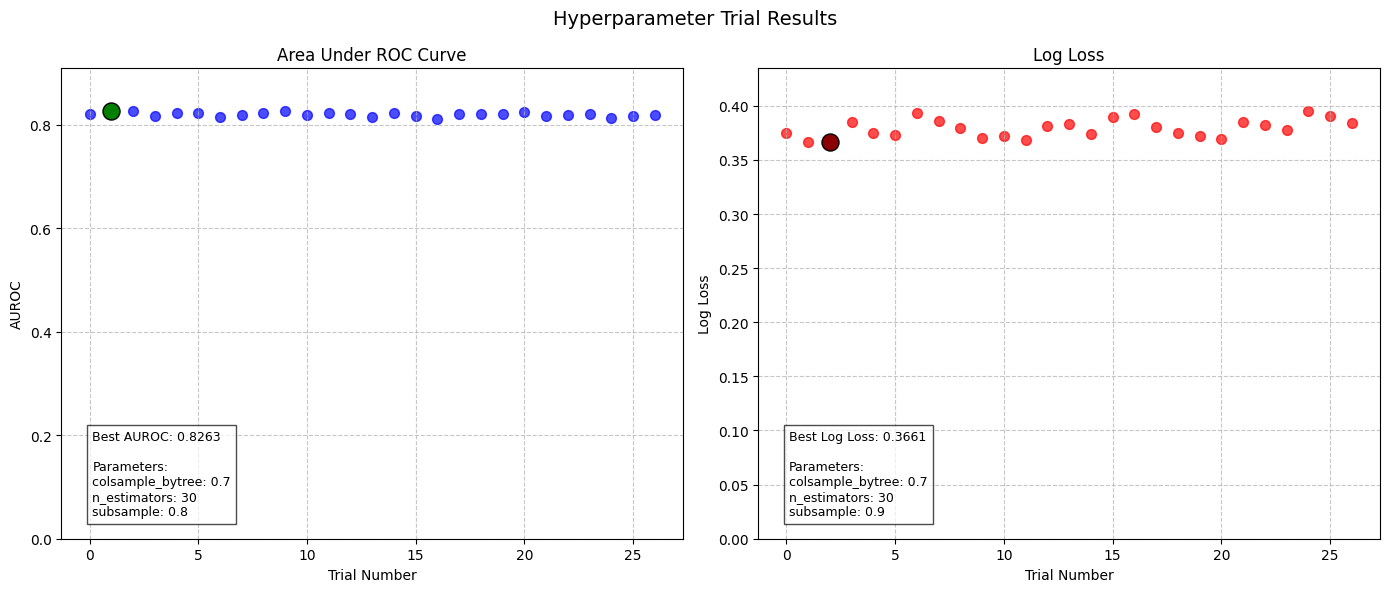

In [90]:
from patientflow.viz.training_results import plot_trial_results
fig = plot_trial_results(trained_models[prediction_time_model_name].training_results.training_info['cv_trials'])


In [91]:
# After sigmoid calibration
print(f"Results for each training run are saved using the hyperparameters as keys:")

for key, value in trained_models[prediction_time_model_name].training_results.test_results.items():
    print(f"{key}: {value:.2f}")


Results for each training run are saved using the hyperparameters as keys:
test_auc: 0.84
test_logloss: 0.41
test_auprc: 0.60


### Plot feature importances and shap plots for each of the five models

The following cells show Shap plots and feature importance plots for each of the five prediction times.

- **Feature Importance Plot**
A feature importance plot is a visual representation that shows the significance of each feature (or variable) in a machine learning model. It helps to understand which features contribute most to the model's predictions. The importance of a feature is typically determined by how much it improves the model's performance. The plot tells you which inputs, in overall terms, have the most influence on the output of the model. This plot is particularly useful for model interpretation, and gaining insights into the underlying data.

- **SHAP Plot**
A SHAP (SHapley Additive exPlanations) plot provides a detailed view of the impact each feature has on the prediction of a machine learning model on a particular dataset, which in the case is the test set. Unlike the feature importance plot, SHAP values explain the contribution of each feature for each individual hospital visit in the test set (with each observation being represented as a dot in the plot). SHAP plots combine game theory and local explanations to show how much each feature increases or decreases the prediction for a given visit. This helps to interpret not only the overall model behavior but also the specific decisions for individual visits, offering a more granular and transparent view of model predictions.

#### Feature plots

The cell below shows feature plots for the main model. To see the same for the minimal model, change the model name to 'admissions_minimal'

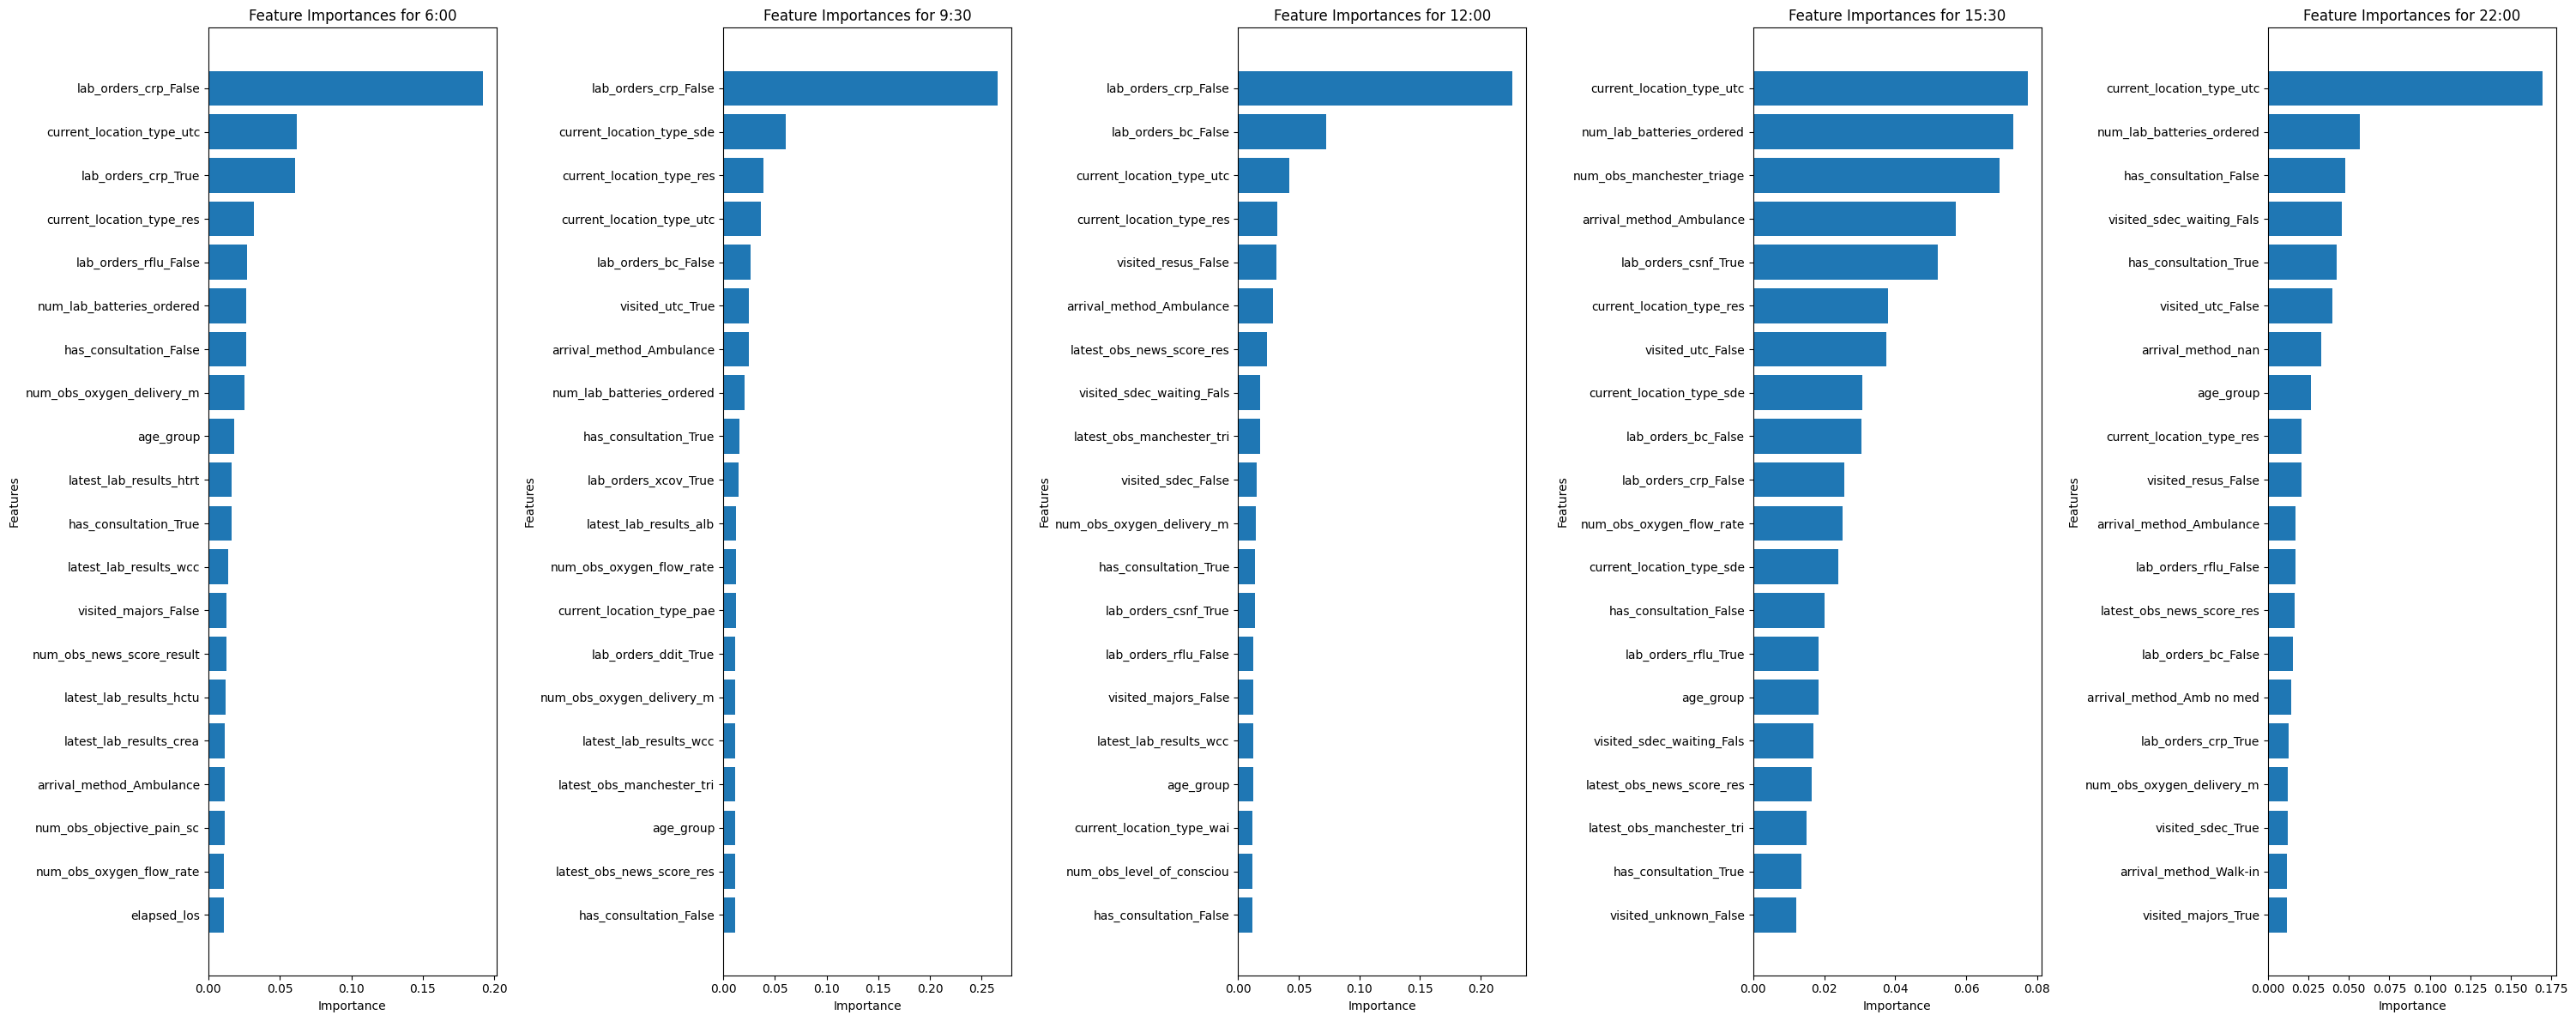

In [51]:
from patientflow.viz.feature_plot import plot_features

plot_features(
    trained_models=None,
    media_file_path=media_file_path,
    prediction_times=ed_visits.prediction_time.unique(),
    model_file_path=model_file_path
)

## Inspecting the base model

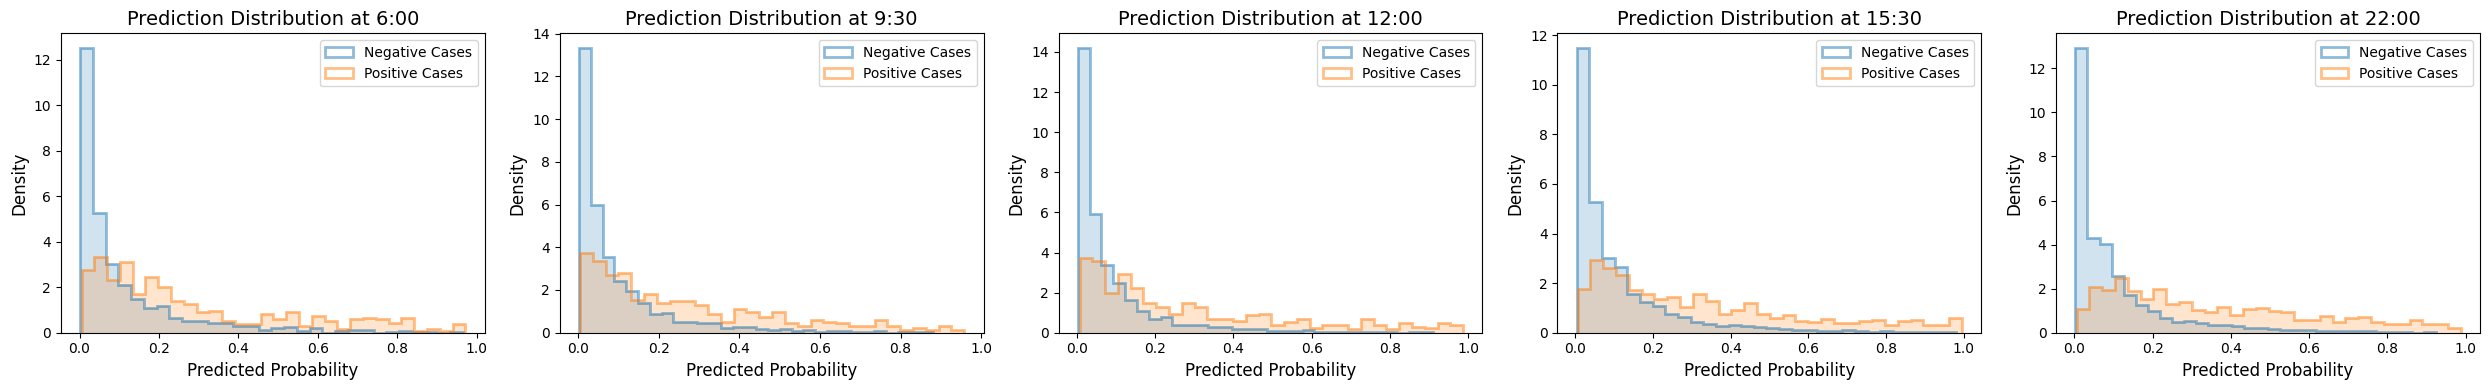

In [92]:
# without balanced training
from patientflow.viz.distribution_plots import plot_prediction_distributions
plot_prediction_distributions(
    prediction_times,
    media_file_path,
    trained_models,
    test_visits,
    exclude_from_training_data,
    model_group_name='admissions',
    # model_name_suffix='calibrated'

)



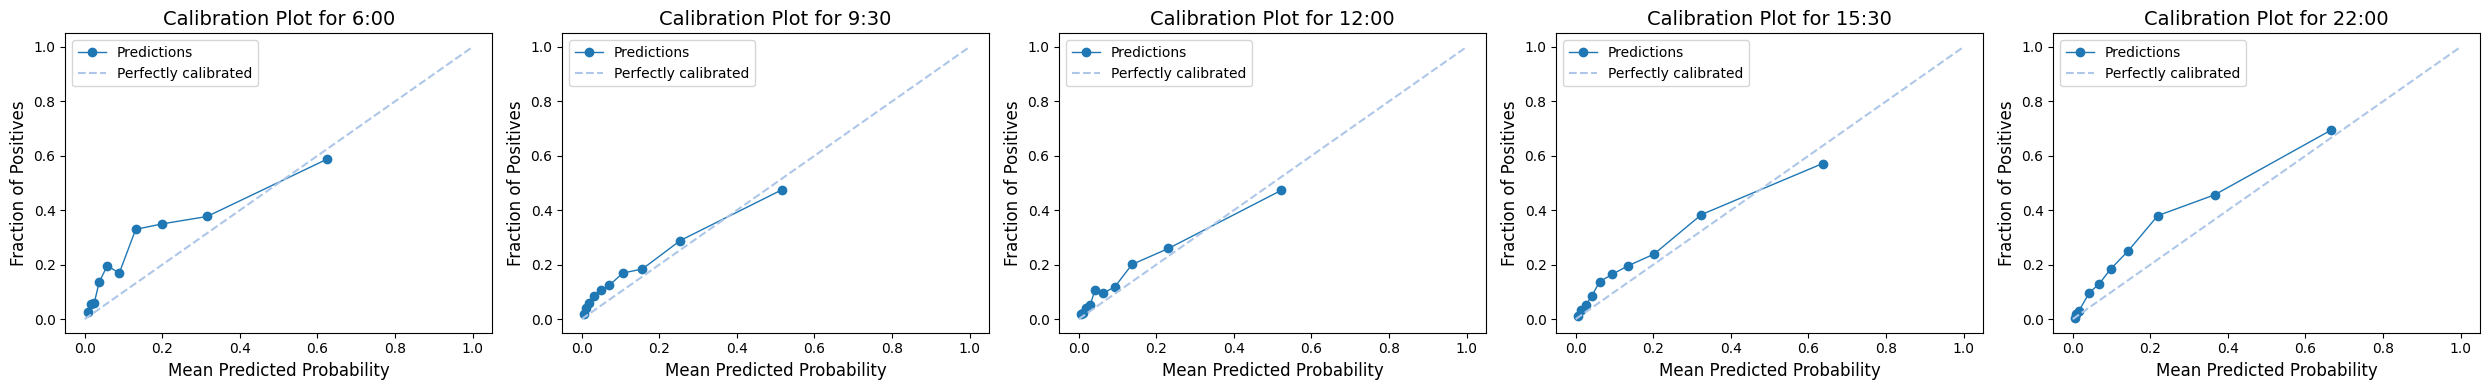

In [93]:
# without balanced training
from patientflow.viz.calibration_plot import plot_calibration
plot_calibration(
    prediction_times,
    media_file_path,
    trained_models,
    test_visits,
    exclude_from_training_data,
    strategy="quantile",
    model_group_name='admissions',
    # model_name_suffix='calibrated'
)

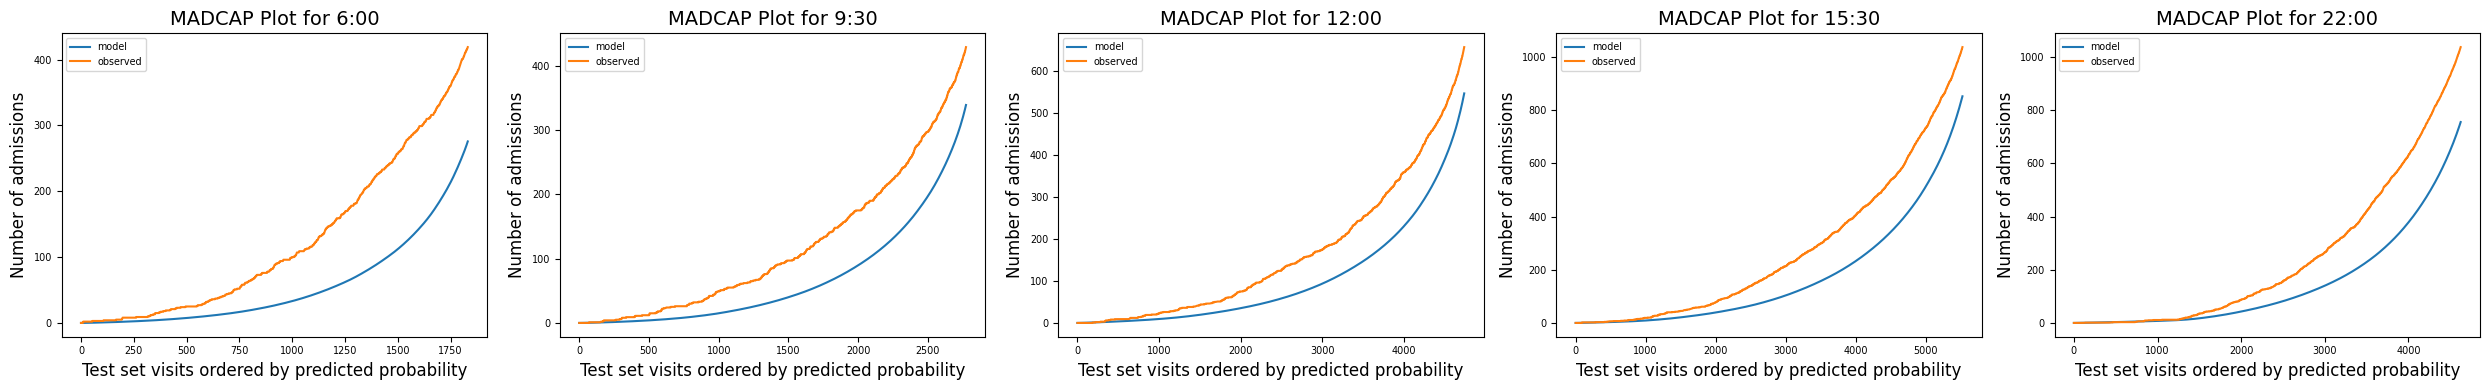

In [94]:
## without balanced training
from patientflow.viz.madcap_plot import generate_madcap_plots
generate_madcap_plots(
    prediction_times,
    media_file_path,
    trained_models,
    test_visits,
    exclude_from_training_data,
    model_group_name = "admissions"
) 

## Trying with balanced samples

In [95]:
# train admissions model
from patientflow.train.classifiers import train_multiple_classifiers

prediction_times = ed_visits.prediction_time.unique()

model_name = 'admissions_balanced'
trained_models_balanced = train_multiple_classifiers(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid=grid,
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_times=prediction_times,
    model_name=model_name,
    calibrate_probabilities=False,
    calibration_method='sigmoid',
    use_balanced_training=True,
    visit_col='visit_number' # visit_col is needed to ensure we get only one snapshot for each visit in the training set; snapshots are randomly sampled
)

# save models and metadata
from patientflow.train.utils import save_model

save_model(trained_models_balanced, model_name, model_file_path)

print(f"Models have been saved to {model_file_path}")


Processing: (12, 0)

Processing: (15, 30)

Processing: (6, 0)

Processing: (9, 30)

Processing: (22, 0)
Models have been saved to /Users/zellaking/Repos/patientflow/trained-models/public


In [103]:
for key, value in trained_models_balanced["admissions_balanced_1530"].training_results.balance_info.items():
    print(f"{key}: {value}")

is_balanced: True
original_size: 14969
balanced_size: 4652
original_positive_rate: 0.15538780145634312
balanced_positive_rate: 0.5
majority_to_minority_ratio: 1.0


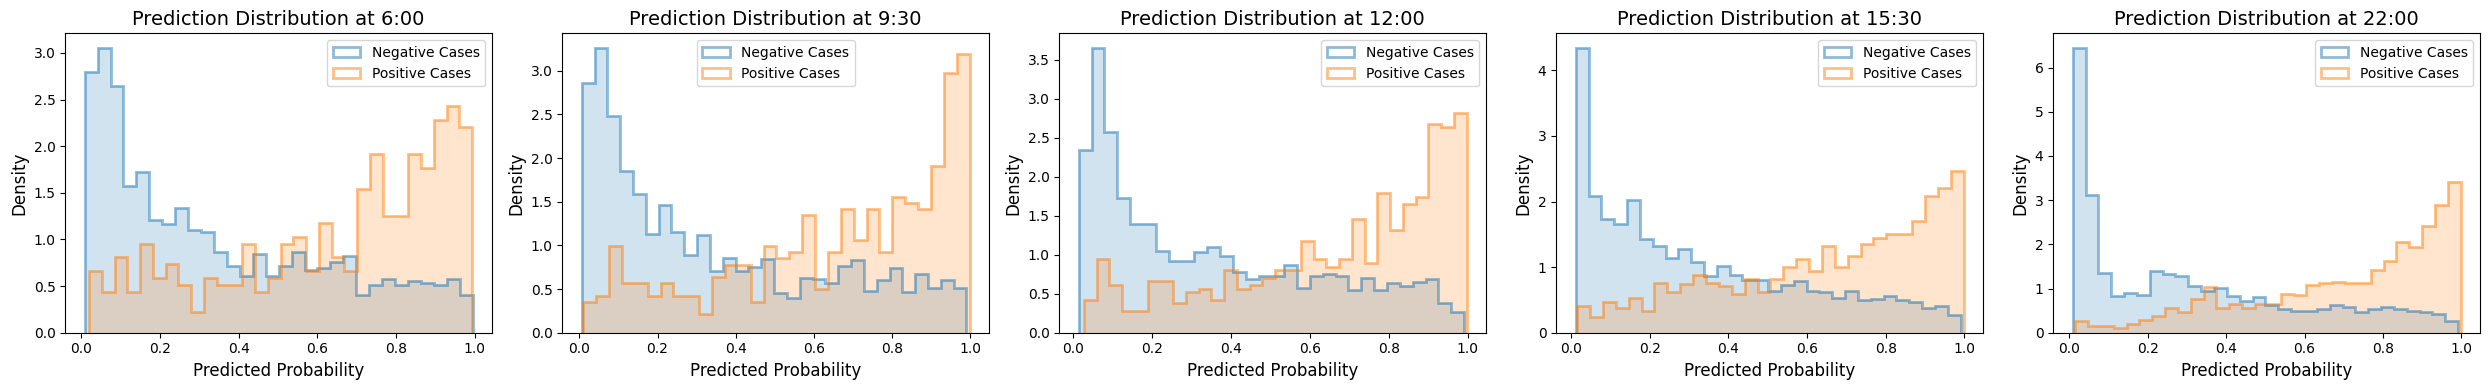

In [104]:
# with balanced training, not calibrated
from patientflow.viz.distribution_plots import plot_prediction_distributions
plot_prediction_distributions(
    prediction_times,
    media_file_path,
    trained_models_balanced,
    test_visits,
    exclude_from_training_data,
    model_group_name='admissions_balanced',
    # model_name_suffix='calibrated'

)

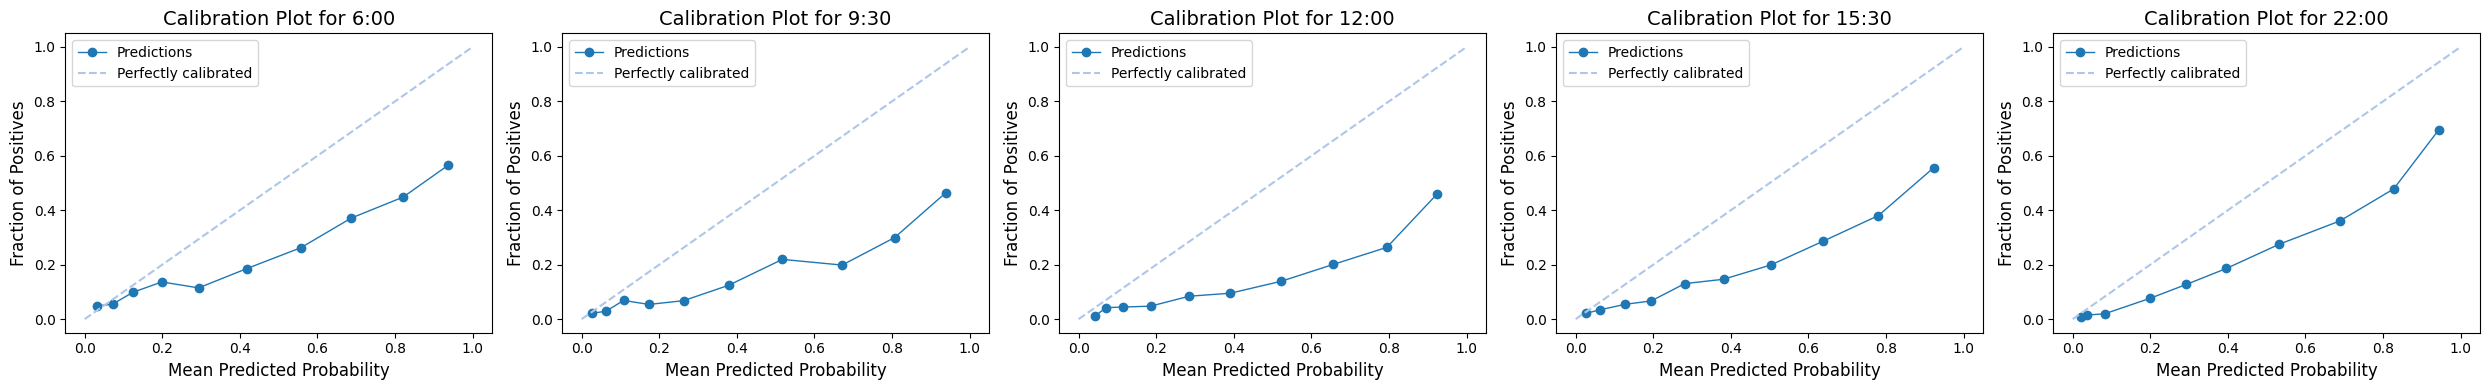

In [105]:
# with balanced training, not calibrated
from patientflow.viz.calibration_plot import plot_calibration
plot_calibration(
    prediction_times,
    media_file_path,
    trained_models_balanced,
    test_visits,
    exclude_from_training_data,
    strategy="quantile",
    model_group_name='admissions_balanced',
    # model_name_suffix='calibrated'
)

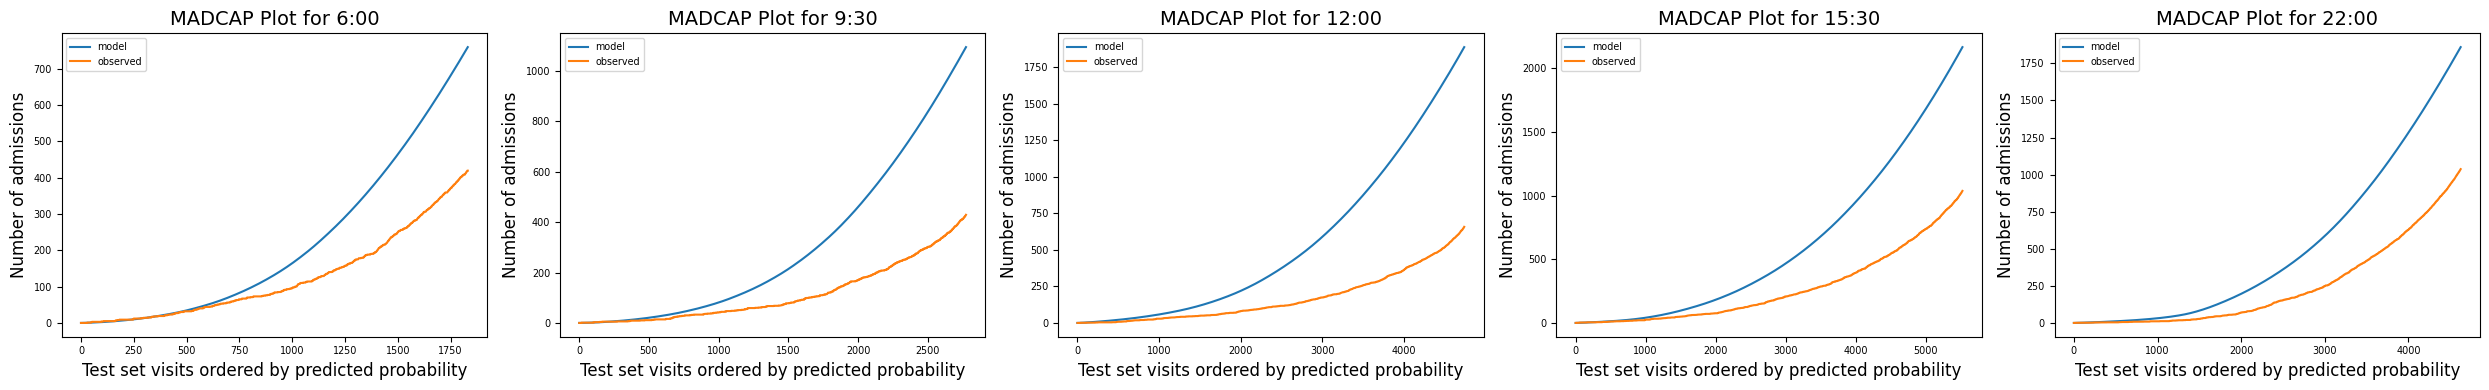

In [106]:
# with balanced training, not calibrated
from patientflow.viz.madcap_plot import generate_madcap_plots
generate_madcap_plots(
    prediction_times,
    media_file_path,
    trained_models_balanced,
    test_visits,
    exclude_from_training_data,
    model_group_name = "admissions_balanced"
) 

## Adding calibration

In [107]:
# train admissions model
from patientflow.train.classifiers import train_multiple_classifiers

prediction_times = ed_visits.prediction_time.unique()

model_name = 'admissions_balanced_calibrated'
trained_models_balanced_calibrated = train_multiple_classifiers(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid=grid,
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_times=prediction_times,
    model_name=model_name,
    calibrate_probabilities=True,
    calibration_method='sigmoid', # Platt scaling
    use_balanced_training=True,
    visit_col='visit_number' # visit_col is needed to ensure we get only one snapshot for each visit in the training set; snapshots are randomly sampled
)

# save models and metadata
from patientflow.train.utils import save_model

save_model(trained_models_balanced_calibrated, model_name, model_file_path)

print(f"Models have been saved to {model_file_path}")


Processing: (12, 0)

Processing: (15, 30)

Processing: (6, 0)

Processing: (9, 30)

Processing: (22, 0)
Models have been saved to /Users/zellaking/Repos/patientflow/trained-models/public


In [109]:
for key, value in trained_models_balanced_calibrated["admissions_balanced_calibrated_1530"].training_results.balance_info.items():
    print(f"{key}: {value}")

is_balanced: True
original_size: 14969
balanced_size: 4652
original_positive_rate: 0.15538780145634312
balanced_positive_rate: 0.5
majority_to_minority_ratio: 1.0


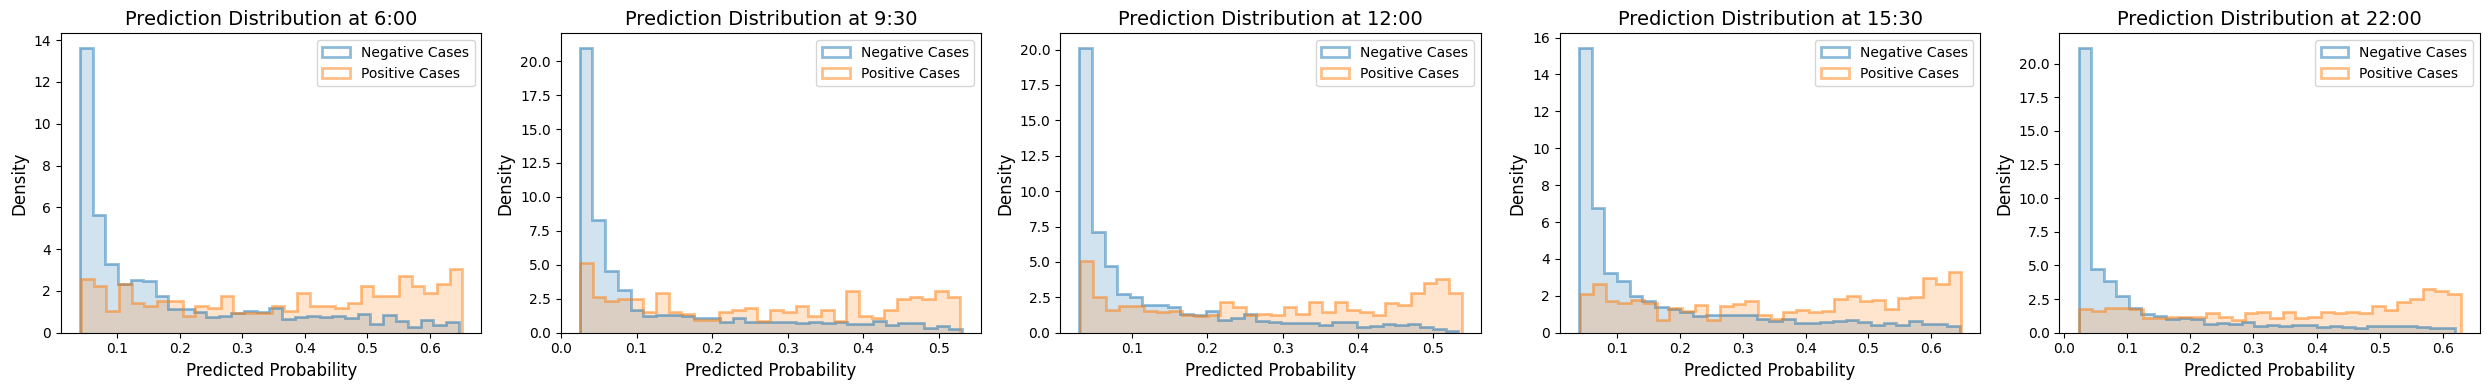

In [110]:
from patientflow.viz.distribution_plots import plot_prediction_distributions
plot_prediction_distributions(
    prediction_times,
    media_file_path,
    trained_models_balanced_calibrated,
    test_visits,
    exclude_from_training_data,
    model_group_name='admissions_balanced_calibrated',
    # model_name_suffix='calibrated'

)

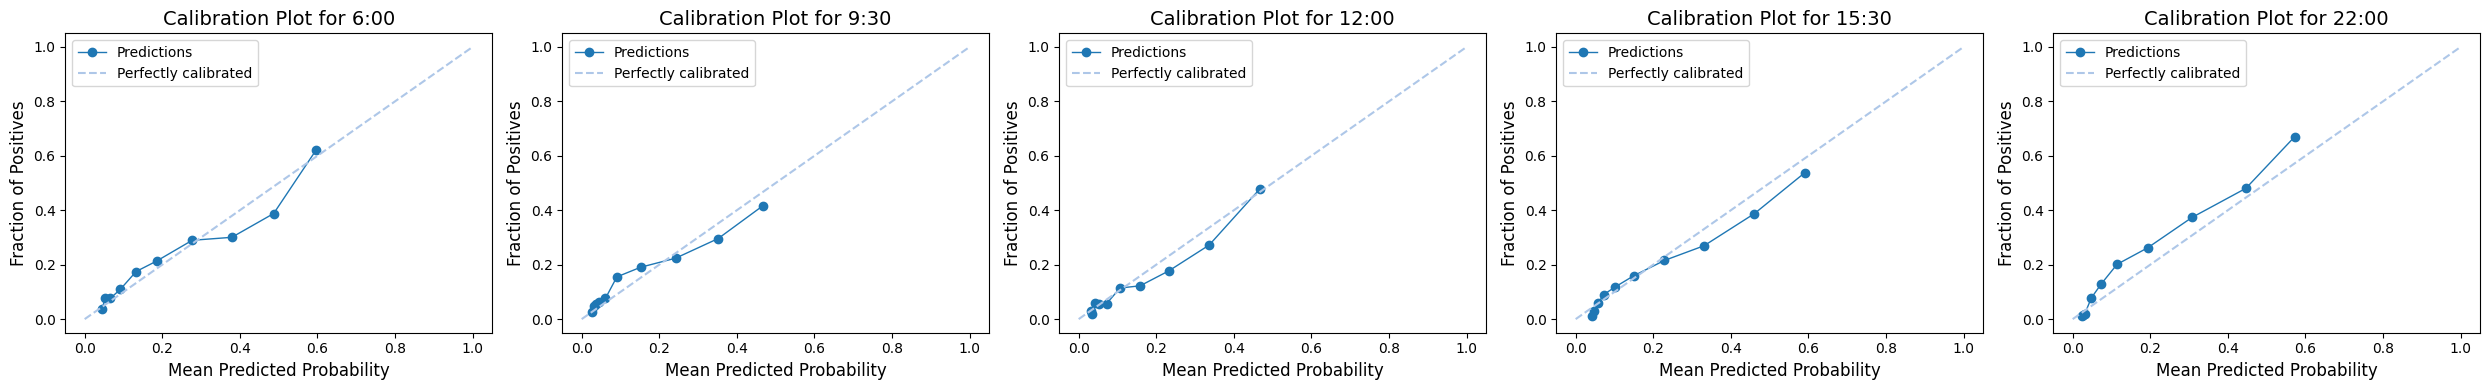

In [111]:
# with balanced training, calibrated
from patientflow.viz.calibration_plot import plot_calibration
plot_calibration(
    prediction_times,
    media_file_path,
    trained_models_balanced_calibrated,
    test_visits,
    exclude_from_training_data,
    strategy="quantile",
    model_group_name='admissions_balanced_calibrated',
    # model_name_suffix='calibrated'

)

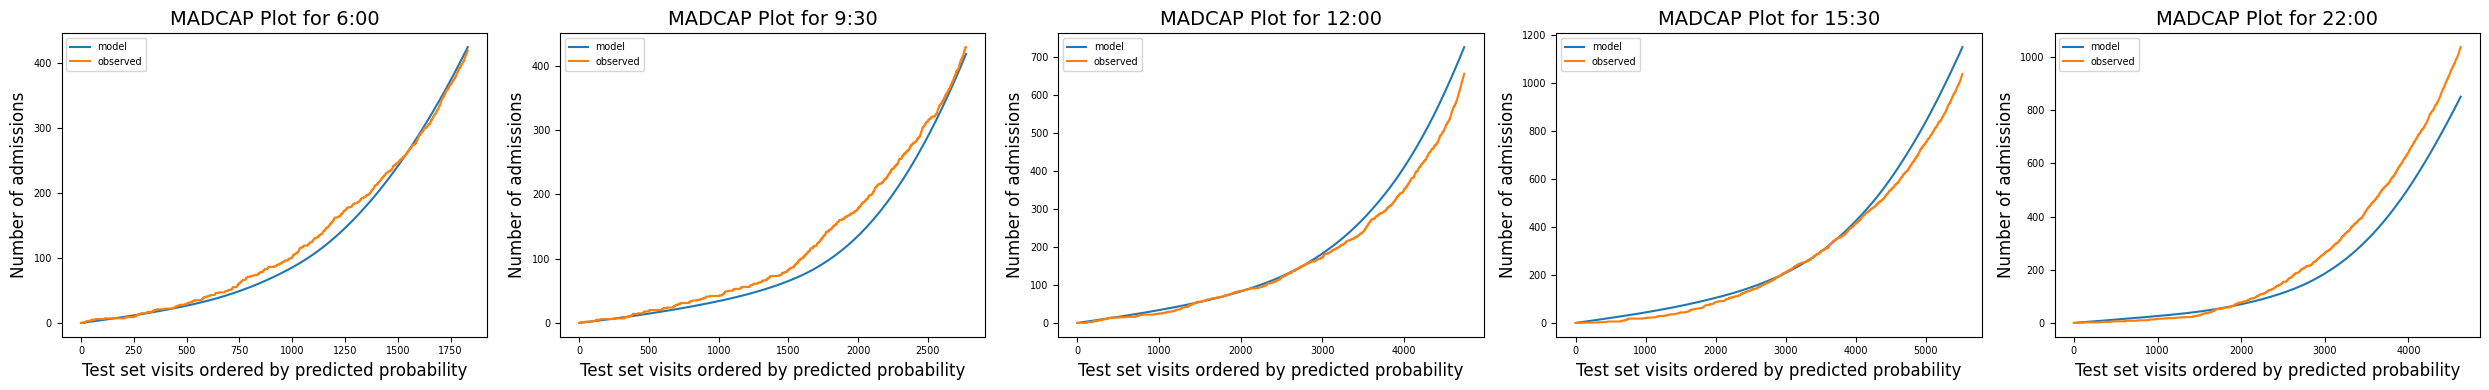

In [112]:
# with balanced training, calibrated
from patientflow.viz.madcap_plot import generate_madcap_plots
generate_madcap_plots(
    prediction_times,
    media_file_path,
    trained_models_balanced_calibrated,
    test_visits,
    exclude_from_training_data,
    model_group_name = "admissions_balanced_calibrated"
) 

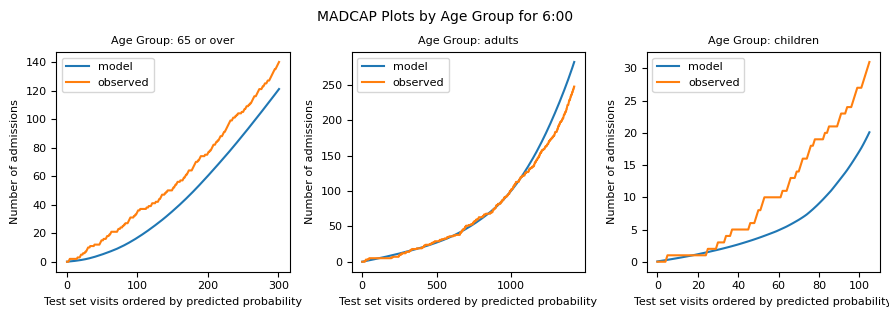

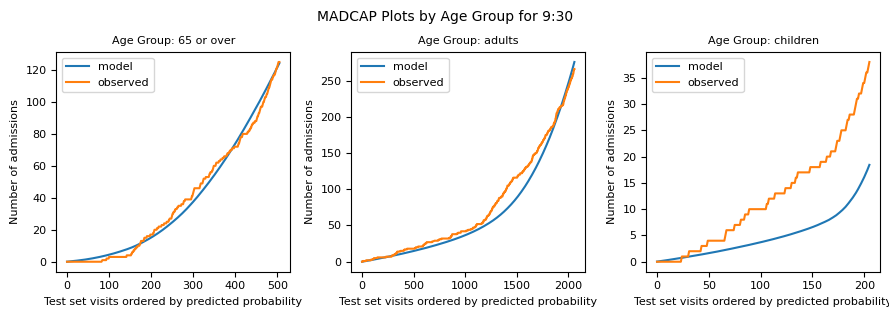

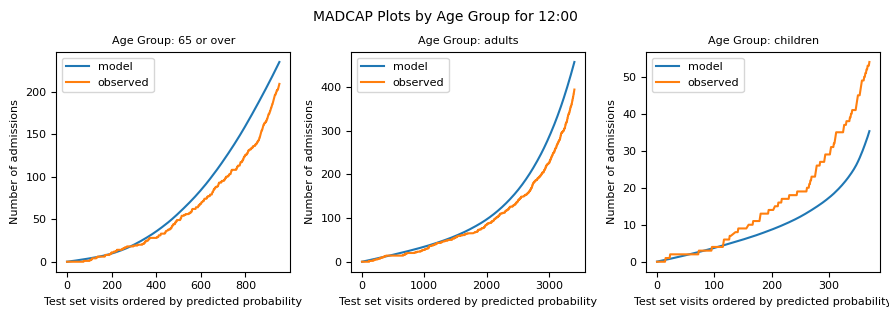

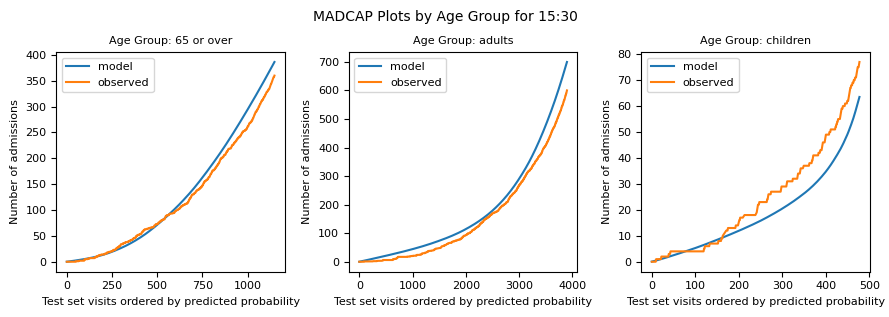

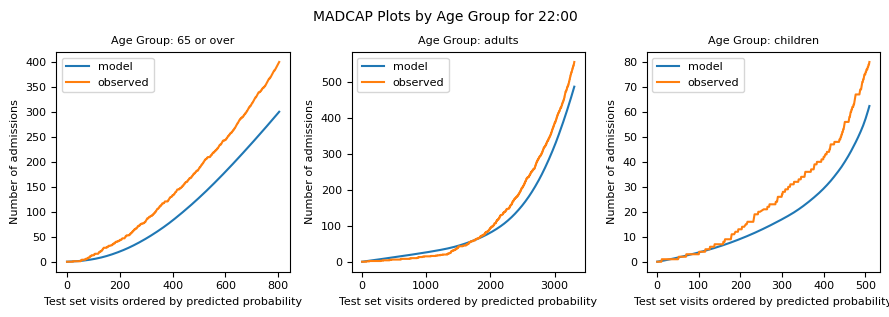

In [113]:
from patientflow.viz.madcap_plot import generate_madcap_plots_by_group
generate_madcap_plots_by_group(
    prediction_times,
    media_file_path,
    trained_models_balanced_calibrated,
    test_visits,
    exclude_from_training_data,
    model_group_name = "admissions_balanced_calibrated",
    grouping_var = "age_group",
    grouping_var_name = "Age Group"
) 



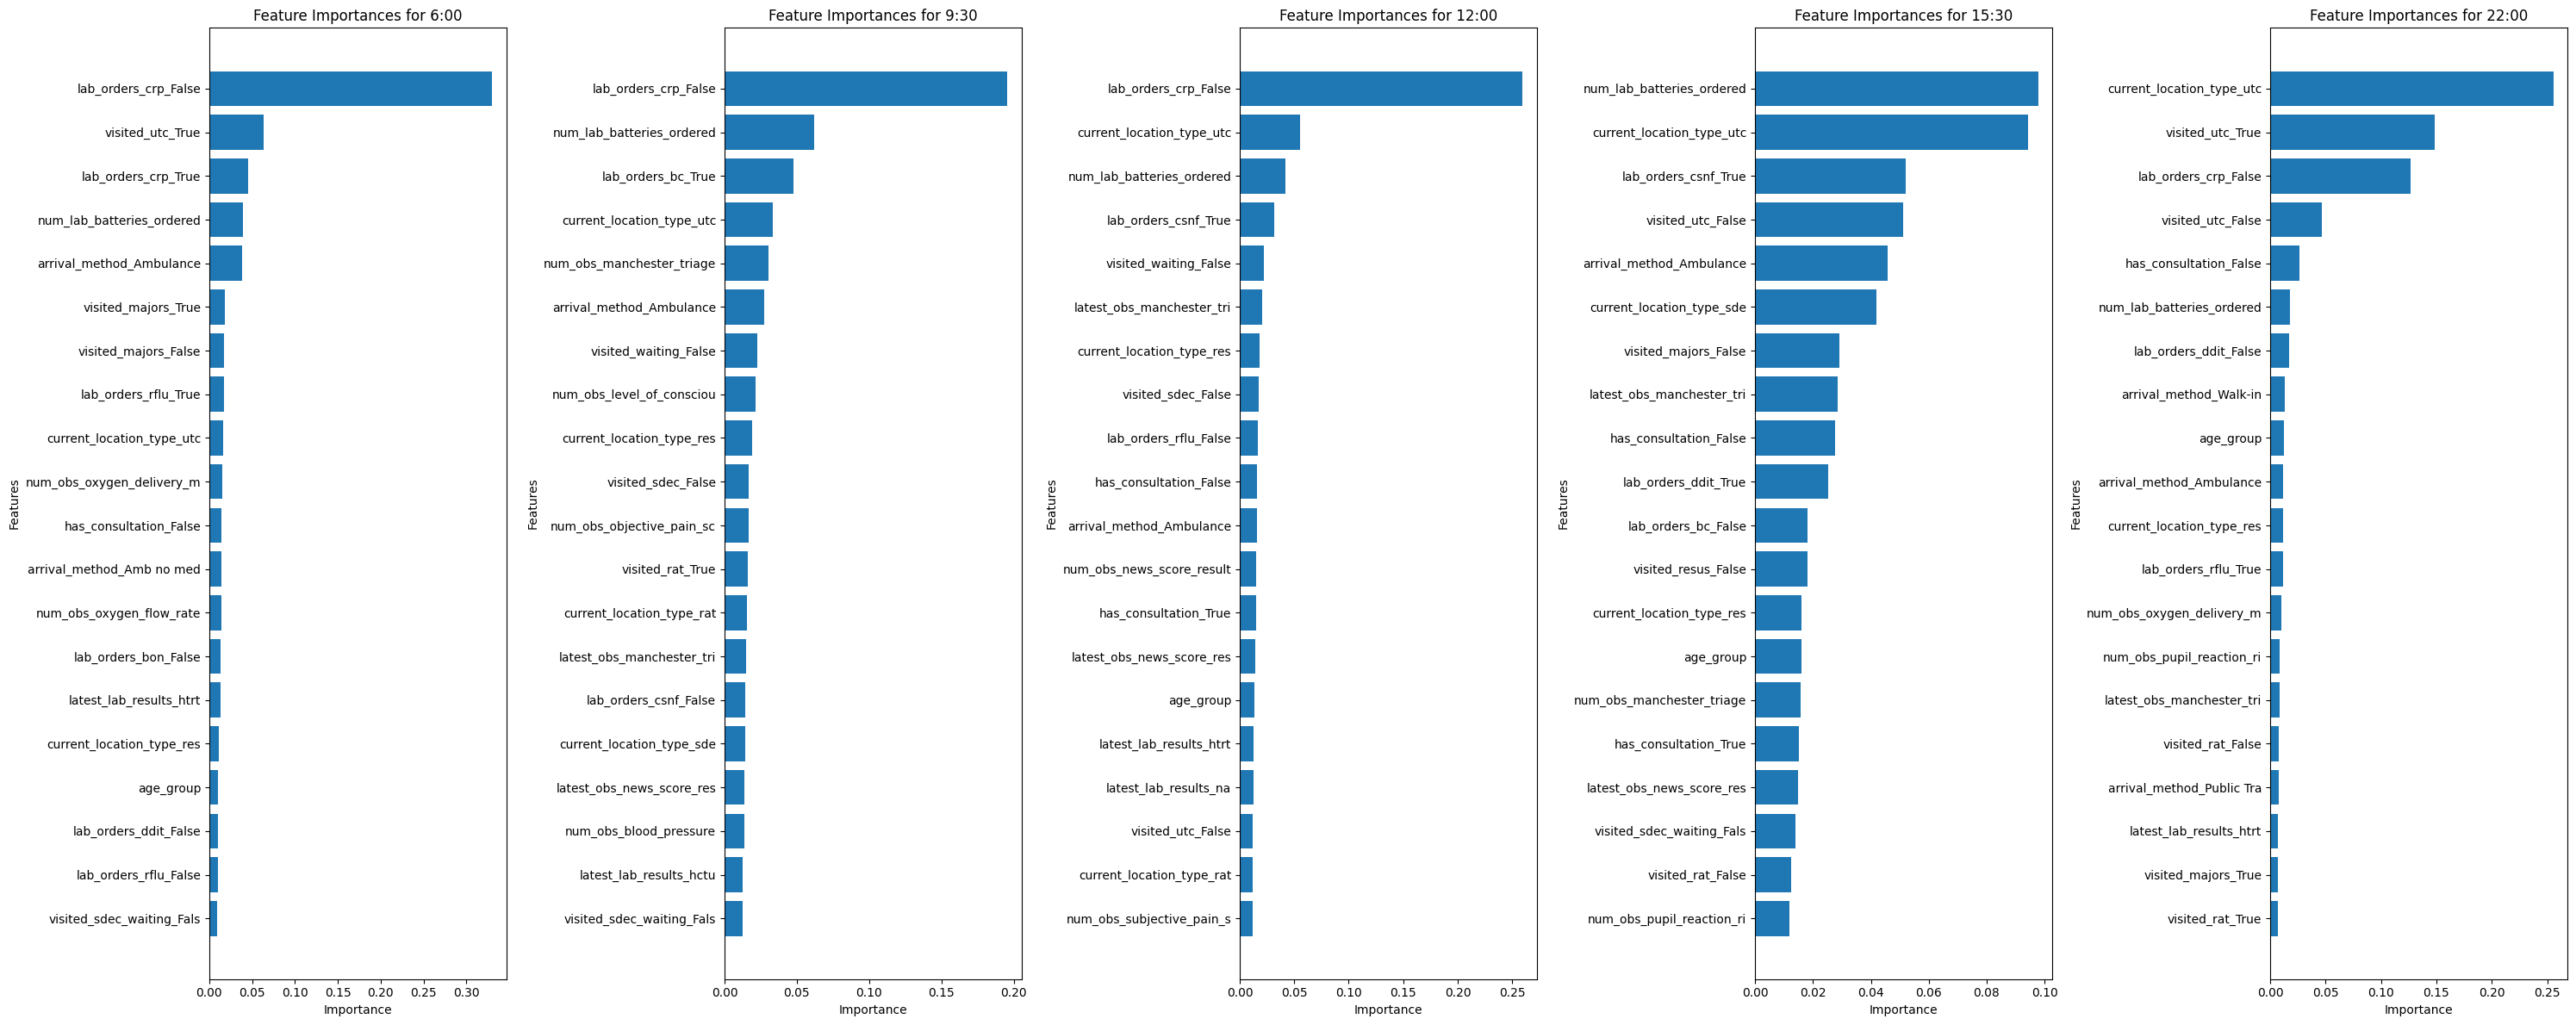

In [114]:
from patientflow.viz.feature_plot import plot_features

plot_features(
    trained_models_balanced_calibrated,
    media_file_path,
    prediction_times,
    model_group_name = "admissions_balanced_calibrated",

)

## Shap plots - main model

The cell below shows SHAP plots for the main model at each prediction time. To see the same for the minimal model, change the model name to 'admissions_minimal'

/Users/zellaking/miniconda3/envs/patientflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted classification (not admitted, admitted):  [1089  743]


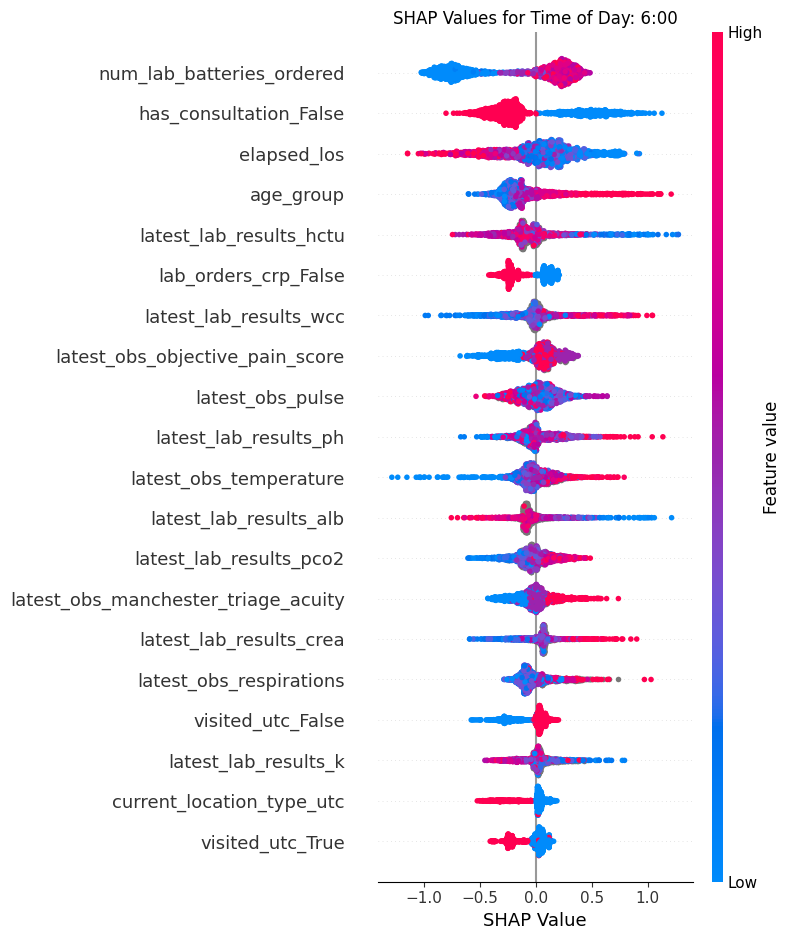

Predicted classification (not admitted, admitted):  [1781  993]


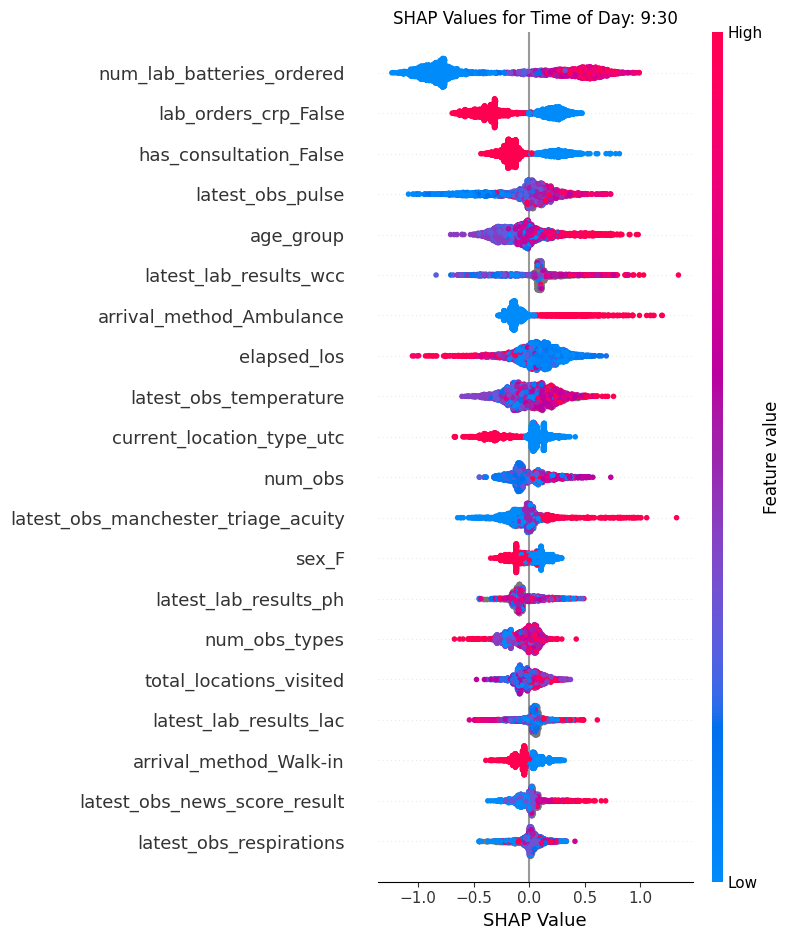

Predicted classification (not admitted, admitted):  [3059 1678]


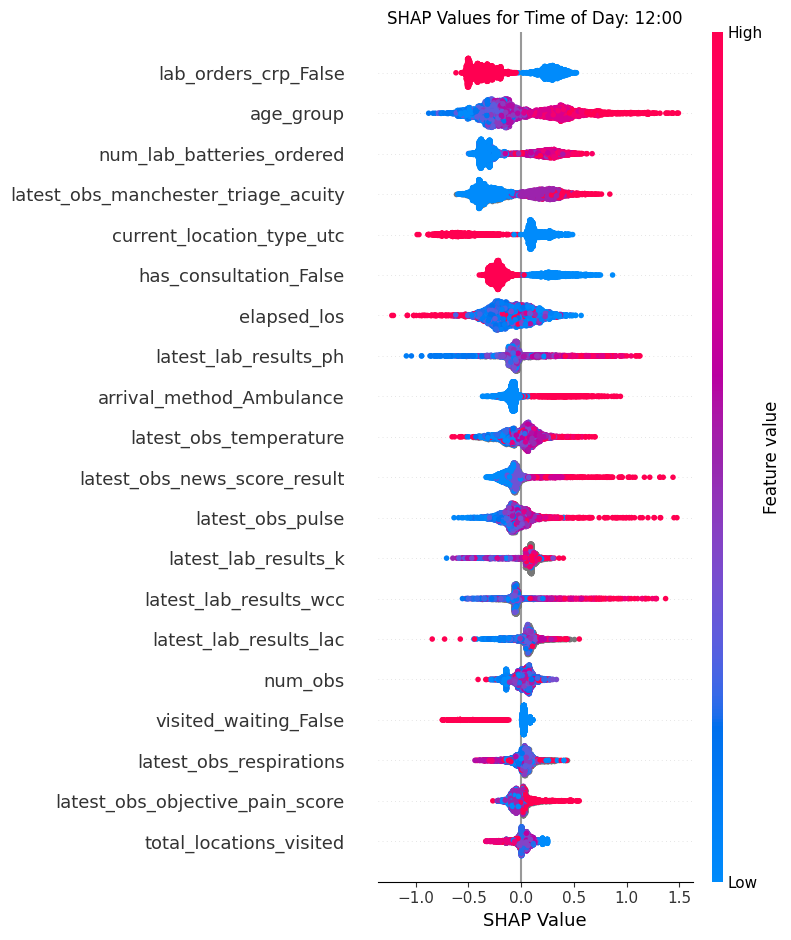

Predicted classification (not admitted, admitted):  [3501 2025]


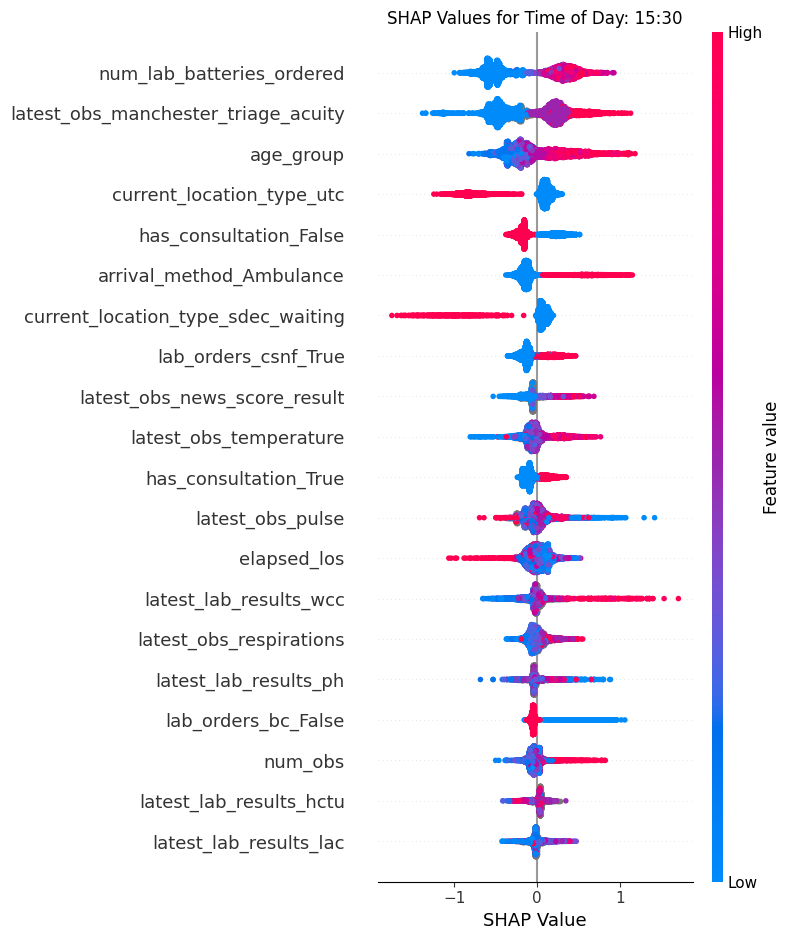

Predicted classification (not admitted, admitted):  [2876 1749]


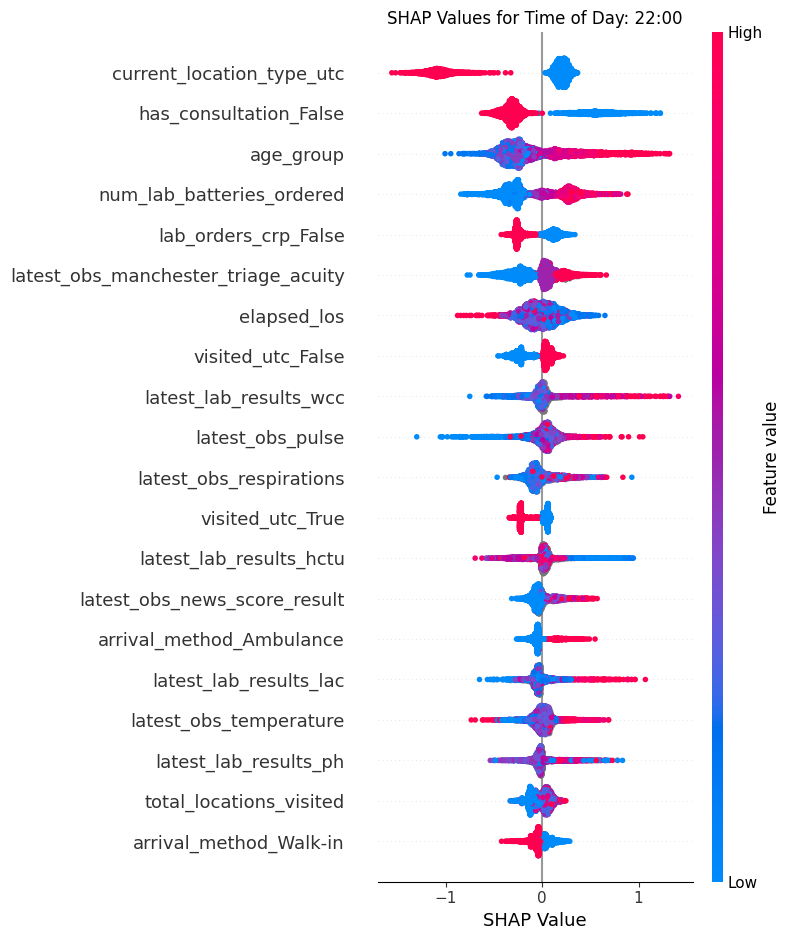

In [115]:
from patientflow.viz.shap_plot import plot_shap
    
plot_shap(trained_models_balanced_calibrated,
    media_file_path,
    test_visits,
    prediction_times,
    exclude_from_training_data,
    model_group_name = 'admissions_balanced_calibrated')